# Topic Modelling of UX Research Job Descriptions

## Introduction

Is it possible to automatically extract specific concepts from a corpus? 

I wanted to see if I could extract and model the frequent, recurring concepts from UX Researcher job postings. Specifically, I wanted to see if it were possible to extract and model the most commonly asked for qualificaitons/skills/experience in UX Researcher job postings, i.e., 'Agile and Scrum methodology', 'A/B testing', 'heuristic evaluation' 'degree in Psychology'. If there are commonly asked for requirements in UX Researcher job postings it stands that these requirements should be able to be modelled automatically. 

There are various ways of topic modelling which include but are not limited to: Latent Dirichlet Allocation (LDA), Non-Negative Matrix Factorisation (NNMF) and term-frequency-inverse-document-frequency (tf-idf). In addition to these models it's possible to extract custom entities from datasets too using Named Entity Recognition (NER). 

## Challenges

Whilst there ought to be some consistency across sought after skills/experience in UX researcher job postings, the field itself is quite broad and as such the postings do not always lend themselves to such neat analysis as jobs such as software engineering where there may be more obvious requirements such as 'Python', 'Javascript' 'OOP' etc...

## Overview 
A project like this can arguably be broken down in these 4 components: 

1. **Data Collection**
2. **Data Cleaning**
3. **Exploratory Data Analysis (EDA)**
4. **Topic Modelling**



In [2]:
import requests
from bs4 import BeautifulSoup
import re
import time
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import gensim
from gensim import models, matutils
from gensim.models import Word2Vec
import gensim.corpora as corpora
from urllib.parse import urljoin
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
import scipy

In [3]:
tokenizer = RegexpTokenizer(r'\w+')

## Step 1 - Data Collection

Data were scraped from Indeed job postings. By formatting the request URL we can scrape through multiple pages, pulling text from each page. By first downlaoding a list of URLs, each containing multiple job postings, we are able to scrape any given quantity in an eaiser way. 

Of course at this stage it might be possible to alter the web-scraper to try and select for those parts of job descriptions which typically contain the 'ideal skills a candidate will have' however, this approach does not lend itself to all types of postings given the unstructured nature of job adverts. It's therefore better to grab all the raw text data, pre-process and then model. 

In [4]:
# Scrapes URLs of multiple job postings across multiple pages on Indeed and saves list of URLs to txt file.
def find_job_links():

  with open('/Users/Alex/PycharmProjects/Python_Corpus_Files/link_list_2.txt.txt', 'w') as f:
    for x in range(0, 300, 10):
      url = f'https://uk.indeed.com/jobs?q=Ux+Researcher&start={x}'
      r = requests.get(url)

      soup = BeautifulSoup(r.content, 'html.parser')
      containers = soup.find_all('h2', class_='title')

      for box in containers:
        base_link = box.find('a')['href']
        link = urljoin('https://uk.indeed.com/', base_link)
        print(link)

        f.write(link + '\n')

# find_job_links()

In [5]:
# Opens txt file of all URLs from previous function, iterates through each URL and grabs job posting text 
# and saves to multiple, numbered files - these files are the raw corpus. 
def grab_descriptions():

  with open('/Users/Alex/PycharmProjects/Python_Corpus_Files/link_list_2.txt', 'r') as f:
      urls = [u.strip('\n') for u in f.readlines()]
      for num, x in enumerate(urls):
        r = requests.get(x)
        print(r.status_code)

        soup = BeautifulSoup(r.content, 'html.parser')
        body = soup.find('div', class_='jobsearch-JobComponent icl-u-xs-mt--sm')

        if body is not None:
          body = body.text
        else:
          continue

        with open(f'/Users/Alex/PycharmProjects/Python_Corpus_Files/300_corpus/file_{num}.txt', 'w') as g:
          g.write(body)

        time.sleep(3)

# grab_descriptions()

## Step 2 - Data Cleaning

The raw text is obviously extremely messy. It's important that we use basic NLP techniques to remove things like punctuation, upper-case letters and stopwords. It's also important to tokenise and lemmatise the corpus (reduce words to single elements and to their 'base' linguistic forms). The data cleaning process is arguably the most important process in this project. The following function should serve as a preliminary round of cleaning, more might have to be conducted later. 

Once each document is properly cleaned they are appended to a list as strings. This list of strings, where every string is a job posting (document) will serve as the input to the later models. This format allows for the use of techniques such as tf-idf whereby we can calculate relative 'weights' of words given their proclivity throughout the dataset (across all documents) and in each document. This can be used as a good measure of recurring topics.

In [6]:
# Opens each individual txt file job posting and applies a variety of NLP pre-processing techniques. 
# Then, each job posting is appended to a list as a string. 
def clean_text_1():
  dataset = []

  # Loads in text files of job descriptions to serve as individual documents
  for x in range(0, 301):
    with open(f'/Users/Alex/PycharmProjects/Python_Corpus_Files/300_corpus/file_{x}.txt', 'r') as f:
      docs = re.sub(r'\\n', '', str(f.read()))

    # Initialising processors + tokenizing for ease of processing
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
    corpus = tokenizer.tokenize(docs)

    # Removing stopwords, uppercase, digits in strings, short words, certain pos tags and lemmatizing
    cleaned_corpus = [item for item in corpus if item not in stopwords.words('english')]
    cleaned_corpus = [item.lower() for item in cleaned_corpus]
    cleaned_corpus = [item for item in cleaned_corpus if all(digit not in item for digit in '1234567890')]
    cleaned_corpus = [item for item in cleaned_corpus if len(item) > 2]
    cleaned_corpus = [item for item in nltk.tag.pos_tag(cleaned_corpus) if item[1] != 'PRP']
    cleaned_corpus = [item for item in cleaned_corpus if item[1] != 'DT']
    cleaned_corpus = [item[0] for item in cleaned_corpus]
    cleaned_corpus = [lemmatizer.lemmatize(item, 'v') for item in cleaned_corpus]
    cleaned_corpus = [lemmatizer.lemmatize(item, 'n') for item in cleaned_corpus]

    # Re-joining so dataset is a list of strings where every string is a
    # document rather than a list of lists where every sublist is a document
    cleaned_corpus = ' '.join(cleaned_corpus)
    

    # Append output to dataset list
    dataset.append(cleaned_corpus)
    
  return dataset

input_set = clean_text_1()

## Step 3 - Exploratory Data Analysis (EDA)

Before doing any actual modelling it's important to analyse textual data. Are there any obvious themes? Do we have too many stopwords still in the corpus? Can we visualise this data? 

By using WordCloud to get a brief overview and then also calcualting actual frequencies of words, it's possible to identify either nonsense words or words that will have no meaning in terms of topics. 

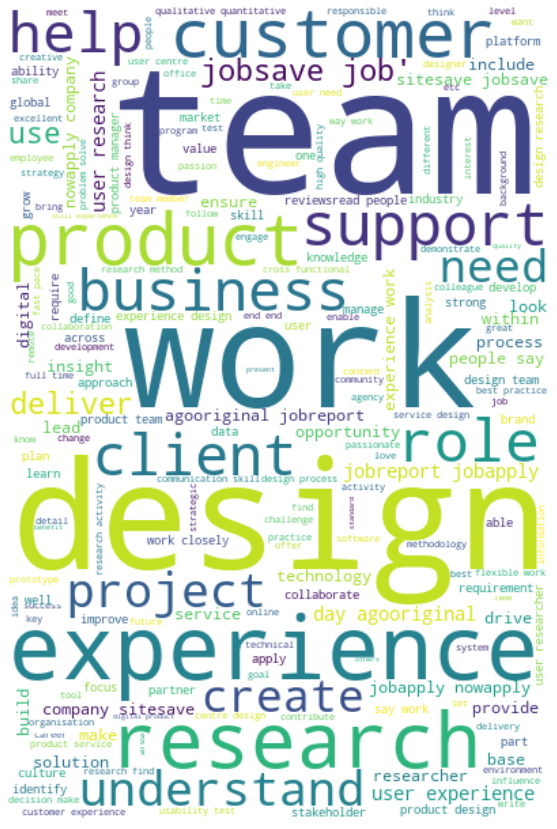

('work', 2287)
('design', 2227)
('experience', 2113)
('research', 1974)
('team', 1813)
('user', 1583)
('product', 1475)
('people', 835)
('business', 805)
('customer', 725)
('researcher', 661)
('understand', 614)
('day', 607)
('service', 606)
('help', 602)
('company', 600)
('role', 589)
('designer', 571)
('digital', 555)
('lead', 546)
('client', 536)
('skill', 517)
('need', 508)
('make', 504)
('job', 503)
('project', 478)
('insight', 476)
('across', 473)
('include', 467)
('support', 463)
('deliver', 459)
('data', 453)
('opportunity', 450)
('process', 442)
('test', 436)
('development', 432)
('look', 426)
('build', 421)
('use', 413)
('new', 409)
('create', 398)
('ability', 373)
('best', 342)
('within', 328)
('drive', 325)
('our', 324)
('develop', 323)
('stakeholder', 320)
('time', 314)
('strong', 310)
('environment', 309)
('plan', 304)
('year', 302)
('way', 301)
('jobapply', 297)
('jobsave', 297)
('problem', 290)
('part', 288)
('solution', 288)
('world', 285)
('jobreport', 283)
('senior',

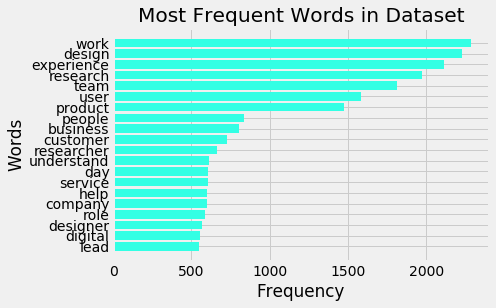

In [7]:
def generate_wc():
  """Exploratory data Analysis - this is an intermediary step to help visualise
     any immediate patterns in the dataset or any more words that should be cleaned"""

  wc = WordCloud(
    background_color='white',
    height=600,
    width=400)

  wc.generate(str(input_set))

  fig = plt.figure(figsize=[15, 15])
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  fig.savefig('eda_wordcloud.png')
  plt.show()
  plt.close()

generate_wc()

def generate_word_freq():
    new_data = tokenizer.tokenize(str(input_set))
  
    frequency_dist = nltk.FreqDist(new_data)
    common = frequency_dist.most_common(20)
  
    plt.style.use('fivethirtyeight')
  
    y = [item[1] for item in common]
    x = [item[0] for item in common]
    
    plt.barh(x, y, color='#33FFE4')
    plt.title('Most Frequent Words in Dataset')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.gca().invert_yaxis()
    
    for w in frequency_dist.most_common(100):
      print(w)


generate_word_freq()

## Data Cleaning - Round 2 

The EDA stage shows us that whilst cleaning has proved effective in terms of noise reduction and normalisation, there is still work to be done before modelling can take place. In terms of additional items to clean, we should look again at: 

1. Function (stop) words 
    * **Within**
    * **Our**
    * **Also**...
2. Noise 
    * **sitesave**
    * **nowapply**
    * **jobreport**...
    
Cleaning does not have to be perfect but adding in more manual cleaning stages is important if we want to reduce as much noise as possible. 
  
        

In [8]:
# Conduct another round of cleaning based on outcome of EDA. 
def clean_text_2():
  
  dataset = []
  
#   Remove 30+ unnecessary, common words and noise words
  noise_list = ['experience','deloitte', 'designer', 'product', 'manager', 'job', 
                'indeedapply', 'jobexpired', 'what','www', 'http', 'com', 
                'london','people', 'saying', 'using', 'take', 'join', 
                'global', 'based', 'make', 'year', 'way','need','team', 
                'end','day', 'jobcompanylocation', 'researcher', 'new', 
                'within', 'best', 'jobapply', 'jobsave', 'jobreport', 
                'agooriginal', 'nowapply', 'sitesave', 'our', 'reviewslondon', 
                'reviewsread', 'researcherserco']

  for doc in input_set:
    cleaned_corpus_2 = tokenizer.tokenize(doc)
    cleaned_corpus_2 = [item for item in cleaned_corpus_2 if item not in noise_list]
    cleaned_corpus_2 = ' '.join(cleaned_corpus_2)

    dataset.append(cleaned_corpus_2)
    
#   print(len(noise_list))
#   print(dataset)

  # Re-check most common words 
  new_data = tokenizer.tokenize(str(dataset))
  
  frequency_dist = nltk.FreqDist(new_data)
    
  for w in frequency_dist.most_common(100):
      print(w)

  return dataset

input_set_2 = clean_text_2()

('work', 2287)
('design', 2227)
('research', 1974)
('user', 1583)
('business', 805)
('customer', 725)
('understand', 614)
('service', 606)
('help', 602)
('company', 600)
('role', 589)
('digital', 555)
('lead', 546)
('client', 536)
('skill', 517)
('project', 478)
('insight', 476)
('across', 473)
('include', 467)
('support', 463)
('deliver', 459)
('data', 453)
('opportunity', 450)
('process', 442)
('test', 436)
('development', 432)
('look', 426)
('build', 421)
('use', 413)
('create', 398)
('ability', 373)
('drive', 325)
('develop', 323)
('stakeholder', 320)
('time', 314)
('strong', 310)
('environment', 309)
('plan', 304)
('problem', 290)
('part', 288)
('solution', 288)
('world', 285)
('senior', 279)
('value', 269)
('technology', 268)
('ensure', 264)
('conduct', 263)
('base', 257)
('provide', 256)
('apply', 256)
('method', 252)
('knowledge', 249)
('learn', 244)
('strategy', 243)
('grow', 238)
('find', 237)
('focus', 235)
('manage', 231)
('market', 231)
('key', 230)
('practice', 225)
('thi

## Step 4 - Topic Modelling

Now we have a more thoroughly cleaned data set it might be possible to start extracting some relevant information from the dataset. If we work on the assumption that, by in large, skills comprise noun phrases (NPs) in language, it might make sense to further process the data into purely NPs. Whilst the data, as a result of the cleaning round may typically already comprise mostly NPs, it's worthwhile to further confirm this. 

From there, we can apply more rigourous topic modelling methods such as tf-idf and LDA. 

In [9]:
def make_tf_idf_model():
  """Starting to build tf-idf model. Note additional cleaning steps
     in the TfidfVectorizer"""

  vectorizer = TfidfVectorizer(lowercase=True,
                               max_features=100,
                               max_df=0.85,
                               min_df=0.01,
                               ngram_range=(3, 3),
                               stop_words='english')

  vectors = vectorizer.fit_transform(input_set_2)
  true_k = 40

  model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
  model.fit(vectors)

  order_centroids = model.cluster_centers_.argsort()[:, ::-1]
  terms = vectorizer.get_feature_names()
    
  tri_gram_set = []

  for i in range(true_k):
        for ind in order_centroids[i, :10]:
            tri_gram_set.append(terms[ind])

  with open("tf-idf_results_ngram_2_topics_30.txt", "w") as f:
    for i in range(true_k):
      f.write(f"Cluster {i}")
      f.write("\n")
      for ind in order_centroids[i, :10]:
        f.write('* %s' % terms[ind], )
        f.write("\n")
      f.write("\n")
      f.write("\n")
        
  return(tri_gram_set)
        
input_set_3 = make_tf_idf_model()

## Results from 1st tf-idf trial

Clearly there are some somewhat meaningful clusters. However there are clear issues with simple tf-idf and k means alone. 

Cluster 0
* alternative identity background
* welcome alternative identity
* human computer interaction
* interview usability test
* psychology human computer
* long term strategy
* high quality design
* empower world build
* equal opportunity employer
* excellent communication skill


Cluster 1
* design interaction design
* work fast pace
* subject matter expert
* excellent communication skill
* benefit package include
* center design method
* user center design
* time say work
* help small business
* employee assistance programme


Cluster 2
* empower world build
* bring world closer
* problem work empower
* billion world share
* help build stronger
* help small business
* cross functional partner
* design interaction design
* play key role
* excellent communication skill


Cluster 3
* human computer interaction
* conduct user research
* user center design
* fast pace environment
* strong communication skill
* work cross functional
* user research activity
* qualitative quantitative data
* precaution remote interview
* play key role


Cluster 4
* qualitative quantitative research
* quantitative research method
* quantitative qualitative research
* user centre design
* psychology human computer
* brand include vogue
* deliver high quality
* user behaviour attitude
* interview usability test
* communicate research result


Cluster 5
* journey map wireframes
* persona journey map
* solve complex problem
* write communication skill
* support business development
* communication skill ability
* wide range research
* human centre design
* work multi disciplinary
* high quality design

## Moving forward - Latent Dirichlet Allocation

Initial TF-IDF results are interesting but can be improved upon. We can use LDA to apply a machine learning-based approach. First, we need to make a document-feature matrix (whereby every job description is a row and every unique term in the entire dataset is a column). Frequencies of terms per document comprise the matrix values. 

In [10]:
tokenized_input = [tokenizer.tokenize(sent) for sent in input_set_2]

In [11]:
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(input_set_2)

data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm = data_dtm.transpose()

In [12]:
sparse_counts = scipy.sparse.csr_matrix(data_dtm)
corpus = matutils.Sparse2Corpus(sparse_counts)

id2word = corpora.Dictionary(tokenized_input)
corpus = [id2word.doc2bow(text) for text in tokenized_input]

In [13]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [14]:
for x in lda_model.print_topics():
    print(x)
    print('\n')


(0, '0.025*"client" + 0.015*"work" + 0.012*"design" + 0.012*"impact" + 0.010*"consult" + 0.010*"service" + 0.008*"business" + 0.008*"value" + 0.007*"purpose" + 0.007*"firm"')


(1, '0.049*"design" + 0.031*"work" + 0.014*"user" + 0.014*"help" + 0.011*"include" + 0.011*"system" + 0.011*"use" + 0.011*"development" + 0.011*"test" + 0.011*"offer"')


(2, '0.000*"research" + 0.000*"work" + 0.000*"user" + 0.000*"design" + 0.000*"help" + 0.000*"role" + 0.000*"service" + 0.000*"customer" + 0.000*"lead" + 0.000*"understand"')


(3, '0.014*"customer" + 0.013*"status" + 0.012*"gender" + 0.011*"paxful" + 0.010*"disability" + 0.009*"race" + 0.008*"origin" + 0.008*"sexual" + 0.008*"orientation" + 0.008*"veteran"')


(4, '0.037*"research" + 0.023*"design" + 0.021*"user" + 0.018*"work" + 0.010*"business" + 0.009*"service" + 0.008*"insight" + 0.008*"skill" + 0.008*"understand" + 0.007*"lead"')


(5, '0.000*"research" + 0.000*"user" + 0.000*"work" + 0.000*"database" + 0.000*"design" + 0.000*"customer" + 